In [1]:
import sys
#dir = '/users/jw/Documents/cGAN_project_1/rcGAN/'
dir = '/home/jjwhit/rcGAN/'
sys.path.append(dir)

In [2]:
import torch
import yaml
import types
import json

import numpy as np
import matplotlib.patches as patches

from data.lightning.MassMappingDataModule import MMDataModule
from data.lightning.MassMappingDataModule import MMDataTransform 
from models.lightning.mmGAN import mmGAN
from utils.mri.math import tensor_to_complex_np
from utils.mri import transforms
from mass_map_utils.scripts.ks_utils import backward_model
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as tkr
from skimage.measure import find_contours

from scipy.ndimage import gaussian_filter

from astropy.io import fits

/home/jjwhit/rcGAN/fastmri/__init__.py:16: UserWarning: Could not retrieve fastmri version!
  warnings.warn("Could not retrieve fastmri version!")


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
def load_object(dct):
    return types.SimpleNamespace(**dct)

In [5]:
#TODO: Step 1: Load model.
torch.set_float32_matmul_precision('medium')

with open(dir+'configs/mass_map.yml', 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg = json.loads(json.dumps(cfg), object_hook=load_object)

dm = MMDataModule(cfg)
fig_count = 1
dm.setup()
test_loader = dm.test_dataloader()

with torch.no_grad():
    mmGAN_model = mmGAN.load_from_checkpoint(
        checkpoint_path='/share/gpu0/jjwhit/mass_map/mm_models/mmgan_training_manual_2/checkpoint_best.ckpt')

    mmGAN_model.cuda()

    mmGAN_model.eval()

In [6]:
COSMOS_VERTICES = [(149.508, 2.880),
                   (149.767, 2.836),
                   (149.780, 2.887),
                   (150.040, 2.842),
                   (150.051, 2.893),
                   (150.363, 2.840),
                   (150.376, 2.890),
                   (150.746, 2.826),
                   (150.737, 2.774),
                   (150.790, 2.765),
                   (150.734, 2.449),
                   (150.787, 2.441),
                   (150.730, 2.125),
                   (150.785, 2.118),
                   (150.758, 2.013),
                   (150.768, 2.010),
                   (150.747, 1.910),
                   (150.799, 1.897),
                   (150.740, 1.580),
                   (150.481, 1.625),
                   (150.466, 1.572),
                   (150.211, 1.619),
                   (150.196, 1.567),
                   (149.887, 1.621),
                   (149.872, 1.571),
                   (149.617, 1.615),
                   (149.602, 1.566),
                   (149.493, 1.584),
                   (149.504, 1.637),
                   (149.450, 1.646),
                   (149.488, 1.855),
                   (149.433, 1.862),
                   (149.491, 2.178),
                   (149.436, 2.186),
                   (149.484, 2.445),
                   (149.431, 2.455),
                   (149.508, 2.880)]

In [18]:
from lenspack.geometry.projections import gnom
def get_extend_radec(res, width):
    ra0, dec0 = (150.11, 2.24) # from cosmos.astro.caltech.edu (could also just use the medians of positions)
    proj = gnom.projector(ra0, dec0)
    pix_size = res #arcmin
    dx = np.deg2rad(width*pix_size/60./2) # number of degrees across
    dy = dx
    extent_xy = [-dx, dx, -dy, dy]
    ra_min, dec_min = proj.xy2radec(-dx, -dy)
    ra_max, dec_max = proj.xy2radec(dx, dy)
    extent_radec = [ra_min, ra_max, dec_min, dec_max]
    return extent_radec

In [19]:
cosmos_shear = np.load(dir+'mass_map_utils/cosmos/cosmos_shear_cropped.npy')
cosmos_shear_tensor = transforms.to_tensor(cosmos_shear)
cosmos_shear_tensor = cosmos_shear_tensor.permute(2, 0, 1)
cosmos_shear_tensor = cosmos_shear_tensor[None,:, :, :].cuda() #batch size?

In [20]:
cosmos_shear_tensor.size()

torch.Size([1, 2, 300, 300])

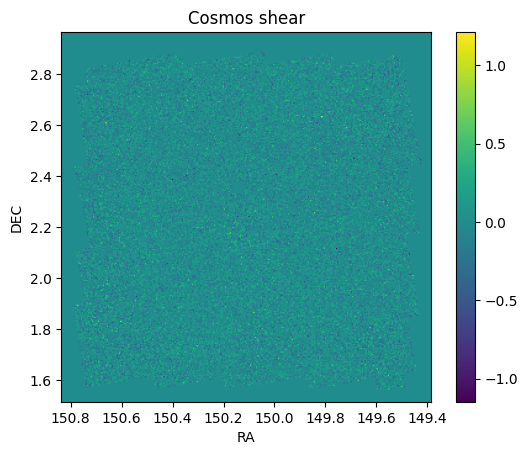

In [21]:
width = 300
resolution = 0.29

fig, axes = plt.subplots(1,1)

#ra, dec = np.array(COSMOS_VERTICES).T
#axes.plot(ra,dec,c='w',lw=1)
im1 = axes.imshow(cosmos_shear.real, cmap='viridis',
                     origin='lower',extent=get_extend_radec(resolution,  width), aspect='auto')
axes.invert_xaxis()
axes.set_aspect('equal')
axes.set_title('Cosmos shear')
axes.set_xlabel('RA')
axes.set_ylabel('DEC')
plt.colorbar(im1, ax=axes, shrink=1)
plt.show()

In [22]:
#Load the cosmos posterior samples.
gens_mmGAN = torch.load(dir+'mass_map_utils/cosmos/cosmos_samps_manual')

In [23]:
gens_mmGAN.shape

torch.Size([32, 300, 300, 2])

In [24]:
samp_1  = gens_mmGAN[0,:,:,:].cpu().detach().numpy()

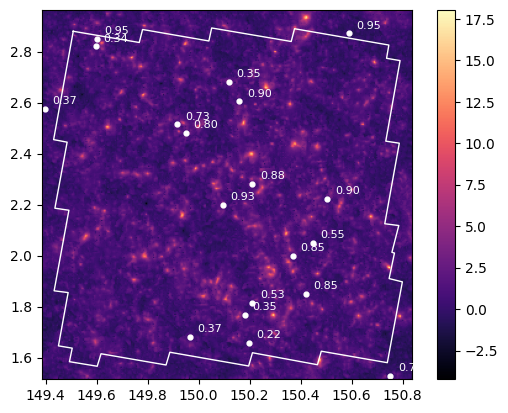

In [25]:
ra, dec = np.array(COSMOS_VERTICES).T
plt.plot(ra,dec,c='w',lw=1)
ax = plt.imshow(samp_1[:,:,0],extent=get_extend_radec(0.29, 300), cmap='magma')
plt.colorbar()

xclusters = np.loadtxt(dir+"/mass_map_utils/cosmos/xray.txt")
m500min=3
zmin=0.1
zmax=0.99
highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
for cluster in xclusters[highz]:
    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
    m500 = cluster[7]
    if m500 > m500min:
        plt.scatter(ra_cl, dec_cl, c='w', s=12)
        plt.text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')

plt.show()

In [37]:
avg_mmGAN = torch.mean(gens_mmGAN, dim=0)

In [38]:
avg_mmGAN.shape

torch.Size([300, 300, 2])

In [39]:
zfr = mmGAN_model.reformat(cosmos_shear_tensor)

In [40]:
zfr.shape

torch.Size([1, 300, 300, 2])

In [41]:
np_avgs = {
    'mmGAN': None,
}

np_samps = {
    'mmGAN': [],
}

np_stds = {
    'mmGAN': None,
}

In [42]:
kappa_mean = 0.00015744006243248638
kappa_std  = 0.02968584954283938

In [43]:
np_zfr = ndimage.rotate(
    torch.tensor(tensor_to_complex_np((zfr * kappa_std + kappa_mean).cpu())).numpy(), 180)

In [44]:
np_avgs['mmGAN'] = ndimage.rotate(
    torch.tensor(tensor_to_complex_np((avg_mmGAN * kappa_std + kappa_mean).cpu().detach())).numpy(),
    180)

In [45]:
np_avgs['mmGAN'].dtype

dtype('complex64')

In [46]:
#for z in range(cfg.num_z_test):
for z in range(32):
    np_samps['mmGAN'].append(ndimage.rotate(torch.tensor(
        tensor_to_complex_np((gens_mmGAN[z] * kappa_std + kappa_mean).cpu().detach())).numpy(), 180))


np_stds['mmGAN'] = np.std(np.stack(np_samps['mmGAN']), axis=0)

method = 'mmGAN'

In [47]:
np_stds['mmGAN'].shape

(300, 300)

In [48]:
mask =  np.load(
                    dir+'mass_map_utils/cosmos/cosmos_mask.npy', allow_pickle=True
                ).astype(bool)

In [49]:
contours = find_contours(mask, 0.5)
outer_contour = max(contours, key=lambda x: x.shape[0])

In [50]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

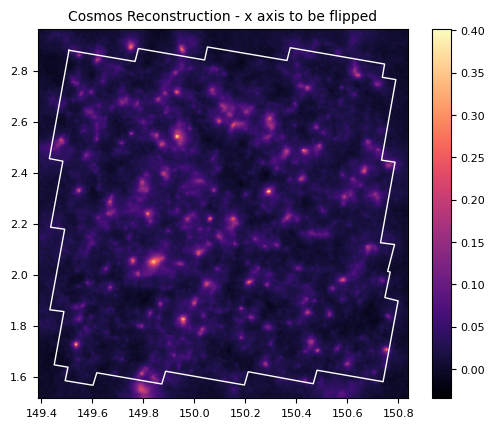

In [51]:
ra, dec = np.array(COSMOS_VERTICES).T
plt.plot(ra,dec,c='w',lw=1)
rotated_img = ndimage.rotate(np_avgs[method], 0)
plt.imshow(rotated_img.real,extent=get_extend_radec(0.29, 300), cmap='magma')
plt.colorbar()

# Overlay xray data
# m500min=3
# zmin=0.1
# zmax=0.99
# highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
# for cluster in xclusters[highz]:
#     ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
#     m500 = cluster[7]
#     if m500 > m500min:
#         plt.scatter(ra_cl, dec_cl, c='w', s=12)
#         plt.text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')
plt.title('Cosmos Reconstruction - x axis to be flipped')
plt.show()

In [52]:
width = 300
resolution = 0.29

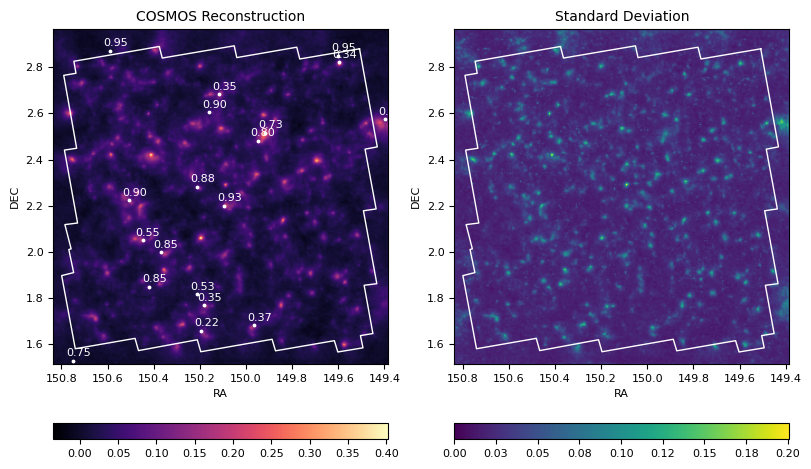

In [53]:
#Fig 1: Global recon, error, std
nrow = 1
ncol = 2
width = 300
resolution = 0.29

fig, axes = plt.subplots(nrow, ncol, figsize=(8,5), constrained_layout=True)

ra, dec = np.array(COSMOS_VERTICES).T
axes[0].plot(ra,dec,c='w',lw=1)

rotated_img = ndimage.rotate(np_avgs[method], 270)
rotated_img = np.flipud(rotated_img)
im1 = axes[0].imshow(rotated_img.real, cmap='magma', vmin=np.min(rotated_img.real), vmax=np.max(np_avgs[method].real),
                     origin='lower',extent=get_extend_radec(resolution,  width), aspect='auto')
axes[0].invert_xaxis()
axes[0].set_aspect('equal')
axes[0].set_title('COSMOS Reconstruction')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('DEC')
plt.colorbar(im1, ax=axes[0], shrink=1, orientation='horizontal',format=tkr.FormatStrFormatter('%.2f'))

m500min=3
zmin=0.1
zmax=0.99
highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
for cluster in xclusters[highz]:
    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
    m500 = cluster[7]
    if m500 > m500min:
        axes[0].scatter(ra_cl, dec_cl, c='w', s=3)
        axes[0].text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')


axes[1].plot(ra,dec,c='w',lw=1)
rotated_sd = ndimage.rotate(np_stds[method].real, 270)
rotated_sd = np.flipud(rotated_sd)
im3 = axes[1].imshow(rotated_sd, cmap='viridis', vmin=0, vmax=np.max(np_stds['mmGAN']), origin='lower',
                     extent=get_extend_radec(resolution,  width), aspect='auto')
axes[1].invert_xaxis()
axes[1].set_aspect('equal')
axes[1].set_title('Standard Deviation')
axes[1].set_xlabel('RA')
axes[1].set_ylabel('DEC')
plt.colorbar(im3, ax=axes[1], shrink=1, orientation='horizontal', format=tkr.FormatStrFormatter('%.2f'))

plt.show()
#plt.savefig(f'/share/gpu0/jjwhit/plots/final/cosmos_results.png', bbox_inches='tight', dpi=300)

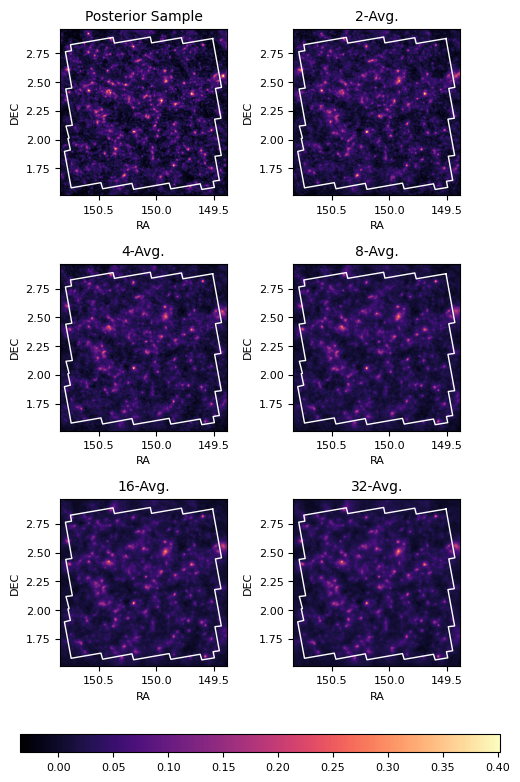

In [54]:
#Plot 7: P-ascent.
nrow = 3
ncol = 2
fig = plt.figure(figsize=(6,9))

gs = gridspec.GridSpec(nrow, ncol,
                       wspace=0.4, hspace=0.15,
                       top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                       left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))

vmin = np.min(np_avgs['mmGAN'].real)
vmax = np.max(np_avgs['mmGAN'].real)


ax = plt.subplot(gs[0, 0])

avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(1):
    avg += np_samps[method][l]

ax.plot(ra,dec,c='w',lw=1)
rotated_img = ndimage.rotate(avg, 270)
rotated_img = np.flipud(rotated_img)
im = ax.imshow(rotated_img.real, cmap='magma', vmin=vmin, vmax=vmax, origin='lower',
          extent=get_extend_radec(resolution,  width), aspect='auto')
#ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('Posterior Sample')
ax1 = ax

ax = plt.subplot(gs[0, 1])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(2):
    avg += np_samps[method][l]

avg = avg / 2
ax.plot(ra,dec,c='w',lw=1)
rotated_img = ndimage.rotate(avg, 270)
rotated_img = np.flipud(rotated_img)
ax.imshow(rotated_img.real,cmap='magma', vmin=vmin, vmax=vmax, origin='lower',
         extent=get_extend_radec(resolution,  width), aspect='auto')
#ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_title('2-Avg.')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax = plt.subplot(gs[1, 0])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(4):
    avg += np_samps[method][l]

avg = avg / 4
ax.plot(ra,dec,c='w',lw=1)
rotated_img = ndimage.rotate(avg, 270)
rotated_img = np.flipud(rotated_img)
ax.imshow(rotated_img.real, cmap='magma', vmin=vmin, vmax=vmax, origin='lower',
         extent=get_extend_radec(resolution,  width), aspect='auto')
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_title('4-Avg.')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax = plt.subplot(gs[1, 1])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(8):
    avg += np_samps[method][l]

avg = avg / 8
ax.plot(ra,dec,c='w',lw=1)
rotated_img = ndimage.rotate(avg, 270)
rotated_img = np.flipud(rotated_img)
ax.imshow(rotated_img.real, cmap='magma', vmin=vmin, vmax=vmax, origin='lower',
         extent=get_extend_radec(resolution,  width), aspect='auto')
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_title('8-Avg.')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax = plt.subplot(gs[2, 0])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(16):
    avg += np_samps[method][l]

avg = avg / 16
ax.plot(ra,dec,c='w',lw=1)
rotated_img = ndimage.rotate(avg, 270)
rotated_img = np.flipud(rotated_img)
ax.imshow(rotated_img.real, cmap='magma', vmin=vmin, vmax=vmax, origin='lower',
         extent=get_extend_radec(resolution,  width), aspect='auto')
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_title('16-Avg.')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax = plt.subplot(gs[2, 1])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(32):
    avg += np_samps[method][l]

avg = avg / 32
ax.plot(ra,dec,c='w',lw=1)
rotated_img = ndimage.rotate(avg, 270)
rotated_img = np.flipud(rotated_img)
ax.imshow(rotated_img.real, cmap='magma', vmin=vmin, vmax=vmax, origin='lower',
         extent=get_extend_radec(resolution,  width), aspect='auto')
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_title('32-Avg.')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.8)


plt.show()
#plt.savefig('/share/gpu0/jjwhit/plots/final/cosmos_P_ascent.png', bbox_inches='tight', dpi=300)

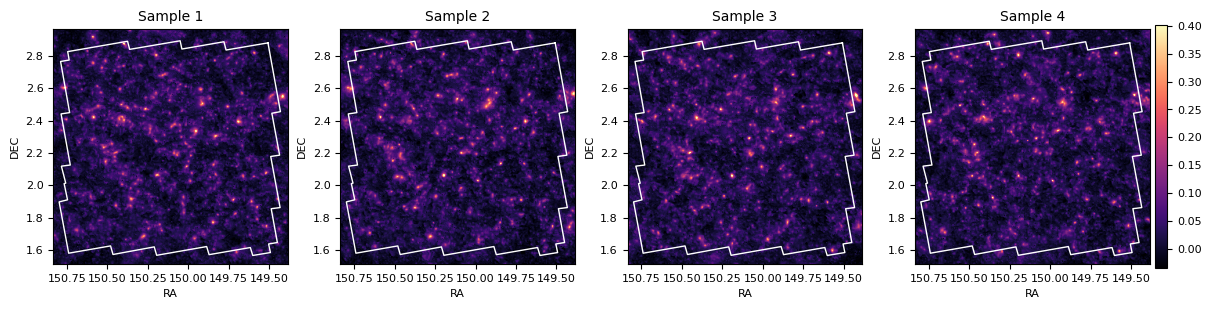

In [55]:
nrow = 1
ncol = 4
fig, axes = plt.subplots(nrow, ncol, figsize=(12,3), constrained_layout=True)

vmin = np.min(np_avgs['mmGAN'].real)
vmax = np.max(np_avgs['mmGAN'].real)

for l in range(4):
    ax = axes[l]

    ax.plot(ra,dec,c='w',lw=1)
    rotated_img = ndimage.rotate(np_samps[method][l], 270)
    #rotated_img = np.flipud(rotated_img)
    im = ax.imshow(rotated_img.real, cmap='magma', vmin=vmin, vmax=vmax,
             extent=get_extend_radec(resolution,  width), aspect='auto')
    #ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
    ax.invert_xaxis()
    ax.set_aspect('equal')
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    ax.set_title(f'Sample {l+1}')
    if l==3:
        cbar = fig.colorbar(im, ax=axes[l], orientation='vertical', pad=0.02, shrink=0.9)
        cbar.mappable.set_clim()


plt.show()
#plt.savefig(f'/share/gpu0/jjwhit/plots/final/cosmos_samples_{fig_count}.png', bbox_inches='tight', dpi=300)

In [56]:
zoom_length = 80  # Adjust this value based on your preference
margin = 10  # Adjust this value to set the margin

# Ensure the square is not touching the edge
zoom_startx = np.random.randint(margin, cfg.im_size - zoom_length - margin)
zoom_starty1 = np.random.randint(margin, int(cfg.im_size / 2) - zoom_length - margin)
zoom_starty2 = np.random.randint(int(cfg.im_size / 2) + margin, cfg.im_size - zoom_length - margin)

p = np.random.rand()
zoom_starty = zoom_starty1 if p <= 0.5 else zoom_starty2

x_coord = zoom_startx + zoom_length
y_coords = [zoom_starty, zoom_starty + zoom_length]

In [57]:
radec_limits = get_extend_radec(resolution,  width)
ra_length = radec_limits[1] - radec_limits[0]
ra_unit = ra_length/300
dec_length = radec_limits[3] -  radec_limits[2]
dec_unit = dec_length/300

ra_start = radec_limits[0] + ra_unit*zoom_startx
ra_end = radec_limits[0] + ra_unit*(zoom_startx + zoom_length)
dec_start = radec_limits[2] + dec_unit*zoom_starty
dec_end = radec_limits[2] + dec_unit*(zoom_starty + zoom_length)
#print(ra_start, ra_end, dec_start, dec_end)

149.58798767034224 149.97492943772545 1.6405672936743902 2.027182331184048


In [58]:
cosmos_dlp = fits.getdata('/share/gpu0/jjwhit/remy2022_results/cosmos/dlp_cosmos_mean_hdu.fits')
start_row = (cosmos_dlp.shape[0] - 300) // 2
start_col = (cosmos_dlp.shape[1] - 300) // 2

# Extract the center 300x300 portion
cosmos_dlp_resized = cosmos_dlp[start_row:start_row + 300, start_col:start_col + 300]
std1 = np.load(
    cfg.cosmo_dir_path + 'cosmos_std1.npy', allow_pickle=True
)
std2 = np.load(
    cfg.cosmo_dir_path + 'cosmos_std2.npy', allow_pickle=True
)
D = MMDataTransform.compute_fourier_kernel(cfg.im_size)
gamma_sim = MMDataTransform.forward_model(np_avgs[method], D) + (
            std1 * np.random.randn(cfg.im_size, cfg.im_size) + 1.j * std2 * np.random.randn(cfg.im_size, cfg.im_size)
        )
cropped_cosmos_shear = np.load(dir+'mass_map_utils/cosmos/cosmos_shear_cropped.npy', allow_pickle=True)
cropped_kernel = MMDataTransform.compute_fourier_kernel(300)

In [59]:
cosmos_dlp_resized.shape

(300, 300)

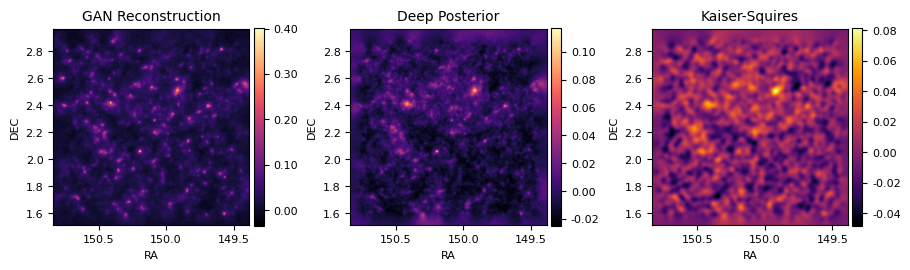

In [62]:
#Plot 6: Kaiser Squires comparison

nrow = 1
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(9,3), constrained_layout=True)

vmin = np.min(np_avgs[method].real)
vmax = np.max(np_avgs[method].real)


rotated_img = ndimage.rotate(np_avgs[method], 270)
im1 = axes[0].imshow(rotated_img.real, cmap='magma', vmin=vmin, vmax=vmax,
                     extent=get_extend_radec(resolution,  width), aspect='auto')
#axes[0].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=0.75)
axes[0].set_title('GAN Reconstruction')
axes[0].invert_xaxis()
axes[0].set_aspect('equal')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('DEC')
#m500min=3
#zmin=0.1
#zmax=0.99
#highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
#for cluster in xclusters[highz]:
#    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
#    m500 = cluster[7]
#    if m500 > m500min:
#        axes[0].scatter(ra_cl, dec_cl, c='w', s=12)
#        axes[0].text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')


flipped_img = np.flipud(cosmos_dlp_resized)
im3 = axes[1].imshow(flipped_img, cmap='magma', 
                    extent=get_extend_radec(resolution,  width), aspect='auto')
#axes[1].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=1)
axes[1].set_title('Deep Posterior')
axes[1].invert_xaxis()
axes[1].set_aspect('equal')
axes[1].set_xlabel('RA')
axes[1].set_ylabel('DEC')
#highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
#for cluster in xclusters[highz]:
#    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
#    m500 = cluster[7]
#    if m500 > m500min:
#        axes[1].scatter(ra_cl, dec_cl, c='w', s=12)
#        axes[1].text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')


cosmos_ks = backward_model(cropped_cosmos_shear, cropped_kernel)
cosmos_smoothed = np.flipud(ndimage.gaussian_filter(cosmos_ks, sigma=1/.29))

im4 = axes[2].imshow(cosmos_smoothed.real, cmap='inferno',
                    extent=get_extend_radec(resolution,  width), aspect='auto') #TODO: Temp
#axes[2].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=1)
axes[2].set_title('Kaiser-Squires')
axes[2].invert_xaxis()
axes[2].set_aspect('equal')
axes[2].set_xlabel('RA')
axes[2].set_ylabel('DEC')

cbar1 = fig.colorbar(im1, ax=axes[0], orientation='vertical', pad=0.02, shrink=0.68,
                     format=tkr.FormatStrFormatter('%.2f'))
cbar1.mappable.set_clim(vmin, vmax)
cbar2 = fig.colorbar(im3, ax=axes[1], orientation='vertical', pad=0.02, shrink=0.68, 
                     format=tkr.FormatStrFormatter('%.2f'))
cbar2.mappable.set_clim()
cbar3 = fig.colorbar(im4, ax=axes[2], orientation='vertical', pad=0.02, shrink=0.68, 
                     format=tkr.FormatStrFormatter('%.2f'))
cbar3.mappable.set_clim()



#plt.show()
plt.savefig('/share/gpu0/jjwhit/plots/final/cosmos_comparison.png', bbox_inches='tight', dpi=300)

In [68]:
cosmos_samps_dlp = fits.getdata('/share/gpu0/jjwhit/remy2022_results/cosmos/dlp_cosmos_samples_hdu.fits')

In [69]:
dlp_std = cosmos_samps_dlp[:,...].std(axis=0)

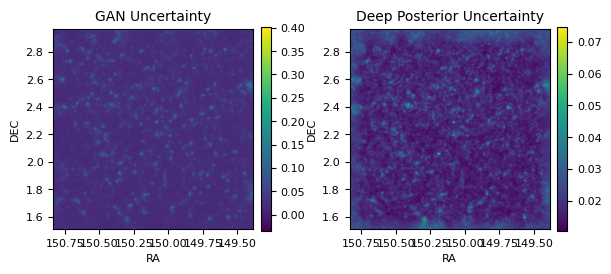

In [79]:
#Plot 6: Kaiser Squires comparison

nrow = 1
ncol = 2
fig, axes = plt.subplots(nrow, ncol, figsize=(6,3), constrained_layout=True)


rotated_img = ndimage.rotate(np_stds[method], 270)
im1 = axes[0].imshow(rotated_img.real, cmap='viridis', vmin=np.min(np_stds[method]), vmax=np.max(np_stds[method]),
                     extent=get_extend_radec(resolution,  width), aspect='auto')
#axes[0].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=0.75)
axes[0].set_title('GAN Uncertainty')
axes[0].invert_xaxis()
axes[0].set_aspect('equal')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('DEC')
#m500min=3
#zmin=0.1
#zmax=0.99
#highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
#for cluster in xclusters[highz]:
#    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
#    m500 = cluster[7]
#    if m500 > m500min:
#        axes[0].scatter(ra_cl, dec_cl, c='w', s=12)
#        axes[0].text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')

flipped_img = np.flipud(dlp_std[30:330, 30:330]) #TODO: ADD  THEIR UNCERTAINTY PLOT HERE
im3 = axes[1].imshow(flipped_img, cmap='viridis', 
                    extent=get_extend_radec(resolution,  width), aspect='auto')
#axes[1].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=1)
axes[1].set_title('Deep Posterior Uncertainty')
axes[1].invert_xaxis()
axes[1].set_aspect('equal')
axes[1].set_xlabel('RA')
axes[1].set_ylabel('DEC')
#highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
#for cluster in xclusters[highz]:
#    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
#    m500 = cluster[7]
#    if m500 > m500min:
#        axes[1].scatter(ra_cl, dec_cl, c='w', s=12)
#        axes[1].text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')

cbar1 = fig.colorbar(im1, ax=axes[0], orientation='vertical', pad=0.02, shrink=0.7)
cbar1.mappable.set_clim(vmin, vmax)
cbar2 = fig.colorbar(im3, ax=axes[1], orientation='vertical', pad=0.02, shrink=0.7)
cbar2.mappable.set_clim()


plt.show()
#plt.savefig('/share/gpu0/jjwhit/plots/final/cosmos_uq_comparison.png', bbox_inches='tight', dpi=300)

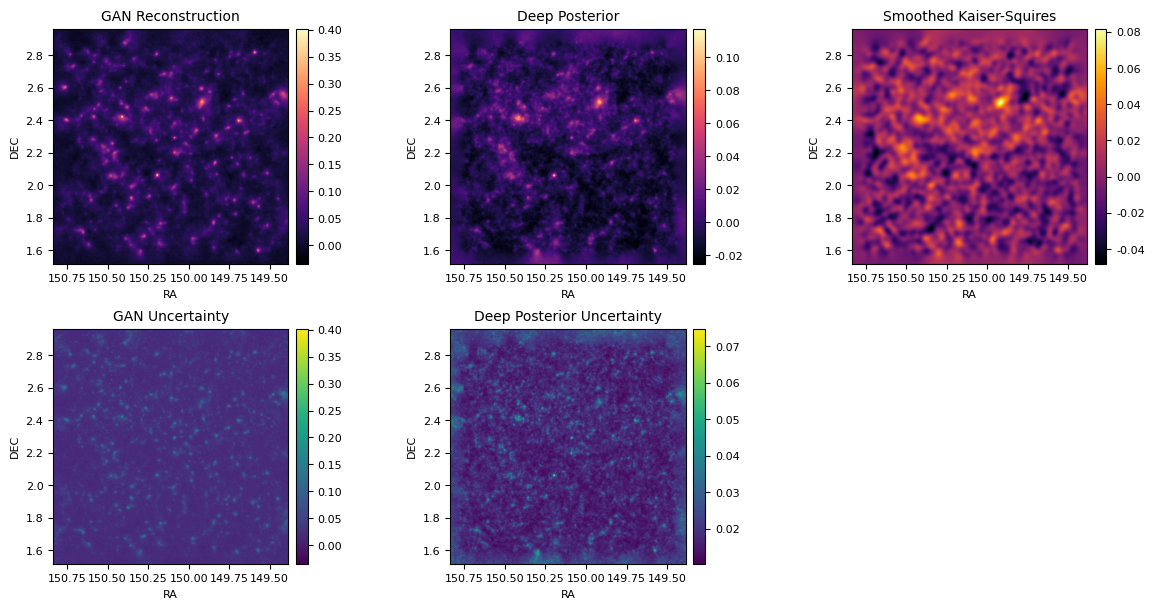

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

# Define your variables and functions here

# Plot 6: Kaiser Squires comparison
fig, axes = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)

# Plot 1: GAN Reconstruction
vmin = np.min(np_avgs[method].real)
vmax = np.max(np_avgs[method].real)
rotated_img = ndimage.rotate(np_avgs[method], 270)
im1 = axes[0, 0].imshow(rotated_img.real, cmap='magma', vmin=vmin, vmax=vmax,
                     extent=get_extend_radec(resolution,  width), aspect='auto')
axes[0, 0].set_title('GAN Reconstruction')
axes[0, 0].invert_xaxis()
axes[0, 0].set_aspect('equal')
axes[0, 0].set_xlabel('RA')
axes[0, 0].set_ylabel('DEC')

# Plot 2: Deep Posterior
flipped_img = np.flipud(cosmos_dlp_resized)
im2 = axes[0, 1].imshow(flipped_img, cmap='magma', 
                    extent=get_extend_radec(resolution,  width), aspect='auto')
axes[0, 1].set_title('Deep Posterior')
axes[0, 1].invert_xaxis()
axes[0, 1].set_aspect('equal')
axes[0, 1].set_xlabel('RA')
axes[0, 1].set_ylabel('DEC')

# Plot 3: Kaiser-Squires
cosmos_ks = backward_model(cropped_cosmos_shear, cropped_kernel)
cosmos_smoothed = np.flipud(ndimage.gaussian_filter(cosmos_ks, sigma=1/.29))
im3 = axes[0, 2].imshow(cosmos_smoothed.real, cmap='inferno',
                    extent=get_extend_radec(resolution,  width), aspect='auto')
axes[0, 2].set_title('Smoothed Kaiser-Squires')
axes[0, 2].invert_xaxis()
axes[0, 2].set_aspect('equal')
axes[0, 2].set_xlabel('RA')
axes[0, 2].set_ylabel('DEC')

# Plot 4: GAN Uncertainty
rotated_img = ndimage.rotate(np_stds[method], 270)
im4 = axes[1, 0].imshow(rotated_img.real, cmap='viridis', vmin=np.min(np_stds[method]), vmax=np.max(np_stds[method]),
                     extent=get_extend_radec(resolution,  width), aspect='auto')
axes[1, 0].set_title('GAN Uncertainty')
axes[1, 0].invert_xaxis()
axes[1, 0].set_aspect('equal')
axes[1, 0].set_xlabel('RA')
axes[1, 0].set_ylabel('DEC')

# Plot 5: Deep Posterior Uncertainty
flipped_img = np.flipud(dlp_std[30:330, 30:330])
im5 = axes[1, 1].imshow(flipped_img, cmap='viridis', 
                    extent=get_extend_radec(resolution,  width), aspect='auto')
axes[1, 1].set_title('Deep Posterior Uncertainty')
axes[1, 1].invert_xaxis()
axes[1, 1].set_aspect('equal')
axes[1, 1].set_xlabel('RA')
axes[1, 1].set_ylabel('DEC')

axes[1, 2].axis('off')


cbar1 = fig.colorbar(im1, ax=axes[0, 0], orientation='vertical', pad=0.02,
                     format=plt.FormatStrFormatter('%.2f'))
cbar1.mappable.set_clim(vmin, vmax)
cbar2 = fig.colorbar(im2, ax=axes[0, 1], orientation='vertical', pad=0.02, 
                     format=plt.FormatStrFormatter('%.2f'))
cbar2.mappable.set_clim()
cbar3 = fig.colorbar(im3, ax=axes[0, 2], orientation='vertical', pad=0.02, 
                     format=plt.FormatStrFormatter('%.2f'))
cbar4 = fig.colorbar(im4, ax=axes[1, 0], orientation='vertical', pad=0.02,
                     format=plt.FormatStrFormatter('%.2f'))
cbar4.mappable.set_clim(vmin, vmax)
cbar5 = fig.colorbar(im5, ax=axes[1, 1], orientation='vertical', pad=0.02,
                     format=plt.FormatStrFormatter('%.2f'))

# Show the combined figure
#plt.show()
plt.savefig('/share/gpu0/jjwhit/plots/final/cosmos_uq_comparison.png', bbox_inches='tight', dpi=300)


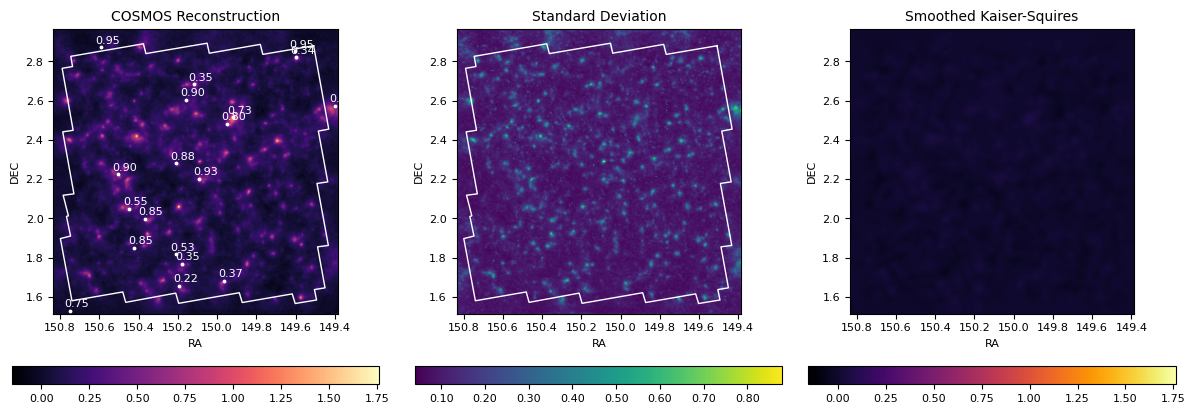

In [55]:
#Plot 6: Kaiser Squires comparison

nrow = 1
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(12,4), constrained_layout=True)

vmin = np.min(np_avgs[method].real)
vmax = np.max(np_avgs[method].real)


ra, dec = np.array(COSMOS_VERTICES).T
axes[0].plot(ra,dec,c='w',lw=1)

rotated_img = ndimage.rotate(np_avgs[method], 270)
rotated_img = np.flipud(rotated_img)
im1 = axes[0].imshow(rotated_img.real, cmap='magma', vmin=np.min(np_avgs[method].real), vmax=np.max(np_avgs[method].real),
                     origin='lower',extent=get_extend_radec(resolution,  width), aspect='auto')
axes[0].invert_xaxis()
axes[0].set_aspect('equal')
axes[0].set_title('COSMOS Reconstruction')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('DEC')
plt.colorbar(im1, ax=axes[0], shrink=1, orientation='horizontal',format=tkr.FormatStrFormatter('%.2f'))

m500min=3
zmin=0.1
zmax=0.99
highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
for cluster in xclusters[highz]:
    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
    m500 = cluster[7]
    if m500 > m500min:
        axes[0].scatter(ra_cl, dec_cl, c='w', s=3)
        axes[0].text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')


axes[1].plot(ra,dec,c='w',lw=1)
rotated_sd = ndimage.rotate(np_stds[method].real, 270)
rotated_sd = np.flipud(rotated_sd)
im3 = axes[1].imshow(rotated_sd, cmap='viridis', vmin=np.min(np_stds['mmGAN']), vmax=np.max(np_stds['mmGAN']), origin='lower',
                     extent=get_extend_radec(resolution,  width), aspect='auto')
axes[1].invert_xaxis()
axes[1].set_aspect('equal')
axes[1].set_title('Standard Deviation')
axes[1].set_xlabel('RA')
axes[1].set_ylabel('DEC')
plt.colorbar(im3, ax=axes[1], shrink=1, orientation='horizontal', format=tkr.FormatStrFormatter('%.2f'))

cosmos_ks = backward_model(cropped_cosmos_shear, cropped_kernel)
cosmos_smoothed = np.flipud(ndimage.gaussian_filter(cosmos_ks, sigma=1/.29))

im4 = axes[2].imshow(cosmos_smoothed.real, cmap='inferno', vmin=np.min(np_avgs[method].real), vmax=np.max(np_avgs[method].real),
                    extent=get_extend_radec(resolution,  width), aspect='auto') #TODO: Temp
axes[2].set_title('Smoothed Kaiser-Squires')
axes[2].invert_xaxis()
axes[2].set_aspect('equal')
axes[2].set_xlabel('RA')
axes[2].set_ylabel('DEC')
plt.colorbar(im4, ax=axes[2], shrink=1, orientation='horizontal', format=tkr.FormatStrFormatter('%.2f'))

plt.show()
#plt.savefig('/share/gpu0/jjwhit/plots/final/cosmos_comparison_2.png', bbox_inches='tight', dpi=300)

In [84]:
#Relative uncertainty
num = ndimage.rotate(np_avgs[method], 270).real - np.flipud(cosmos_dlp_resized)
denom = np.sqrt((np.flipud(ndimage.rotate(np_stds[method].real, 270)))**2 + (np.flipud(dlp_std[30:330, 30:330]))**2)
relative_uncertainty = num/denom

(150.83587487015308, 149.38484324246605)

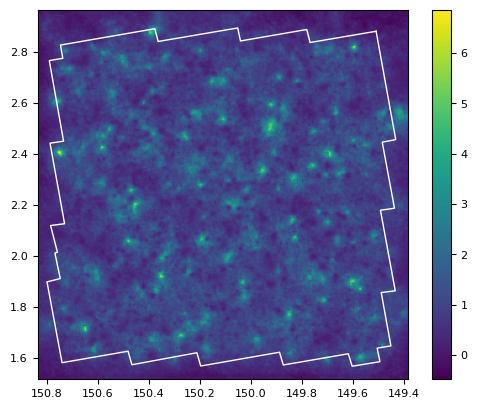

In [90]:
plt.plot(ra,dec,c='w',lw=1)
plt.imshow(relative_uncertainty,extent=get_extend_radec(resolution,  width))
plt.colorbar()
plt.xlim(plt.xlim()[::-1])
plt.title()

In [6]:
cosmos_shear = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_shear_cropped.npy')
cosmos_shear_tensor = transforms.to_tensor(cosmos_shear)
cosmos_shear_tensor = cosmos_shear_tensor.permute(2,0,1).cuda()
#cosmos_shear_tensor = cosmos_shear_tensor[None,:, :, :].cuda()

In [7]:
cosmos_shear_tensor.size()

torch.Size([2, 300, 300])

In [32]:
normalised_gamma_complex, mean_complex, std_complex  = transforms.normalize_instance(cosmos_shear_tensor)
#normalised_gamma_instance, mean, std  = transforms.normalize_instance(cosmos_shear_tensor)

In [33]:
#normalised_gamma_complex = normalised_gamma_complex.cuda()
normalised_gamma_complex = normalised_gamma_complex[None,:, :, :].cuda()
#normalised_gamma_instance = normalised_gamma_instance.cuda()

In [34]:
normalised_gamma_complex.size() #This is correct.

torch.Size([1, 2, 300, 300])

In [35]:
print(mean_complex)
print(std_complex) #These are also fine.

tensor(0.0003, device='cuda:0')
tensor(0.1301, device='cuda:0')


In [36]:
gens_mmGAN = torch.zeros(size=(32,300,300,2)).cuda()

In [37]:
gens_mmGAN.size()

torch.Size([32, 300, 300, 2])

In [38]:
for z in range(32):
    gens_mmGAN[z,:,:,:] = mmGAN_model.reformat(mmGAN_model.forward(normalised_gamma_complex).cuda())

OutOfMemoryError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 79.15 GiB total capacity; 77.51 GiB already allocated; 29.31 MiB free; 78.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [39]:
gens_mmGAN.size()

torch.Size([32, 300, 300, 2])

In [1]:
import sys
#dir = '/users/jw/Documents/cGAN_project_1/rcGAN/'
dir = '/home/jjwhit/rcGAN/'
sys.path.append(dir)
import torch
import yaml
import types
import json

import numpy as np
from data.lightning.MassMappingDataModule import MMDataModule
from data.lightning.MassMappingDataModule import MMDataTransform 
from models.lightning.mmGAN import mmGAN
from utils.mri.math import tensor_to_complex_np
from utils.mri import transforms
from mass_map_utils.scripts.ks_utils import backward_model
from scipy import ndimage

import matplotlib.pyplot as plt
from astropy.io import fits

/home/jjwhit/rcGAN/fastmri/__init__.py:16: UserWarning: Could not retrieve fastmri version!
  warnings.warn("Could not retrieve fastmri version!")


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def load_object(dct):
    return types.SimpleNamespace(**dct)

#TODO: Step 1: Load model.
torch.set_float32_matmul_precision('medium')

with open(dir+'configs/mass_map.yml', 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg = json.loads(json.dumps(cfg), object_hook=load_object)

dm = MMDataModule(cfg)
fig_count = 1
dm.setup()
test_loader = dm.test_dataloader()

with torch.no_grad():
    mmGAN_model = mmGAN.load_from_checkpoint(
        checkpoint_path='/share/gpu0/jjwhit/mass_map/mm_models/mmgan_training_manual_2/checkpoint_best.ckpt')

    mmGAN_model.cuda()

    mmGAN_model.eval()

In [3]:
ground_truth = np.load('/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_val/cropped_sim_08773.npy', allow_pickle=True) #real

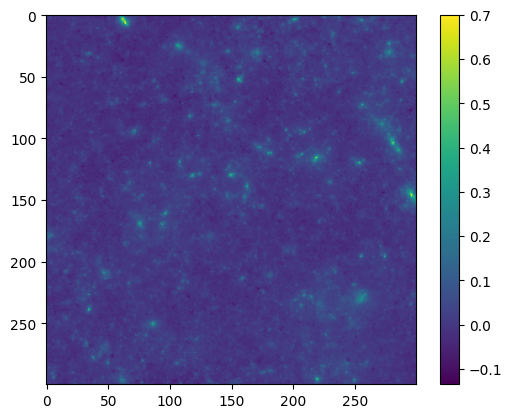

In [4]:
plt.imshow(ground_truth)
plt.colorbar()
plt.show()

In [15]:
shear =  np.load('/share/gpu0/jjwhit/cropped_shear.npy', allow_pickle=True) #complex-valued

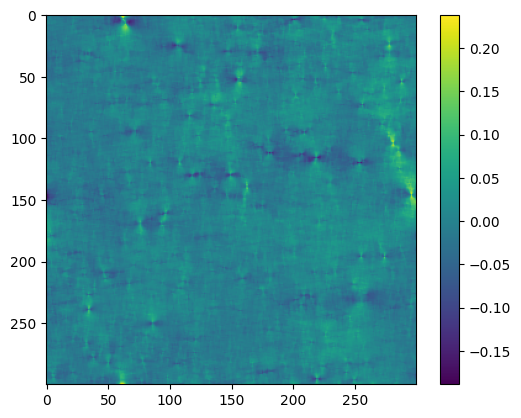

In [16]:
plt.imshow(shear.real)
plt.colorbar()
plt.show()

In [7]:
shear_tensor = transforms.to_tensor(shear)
shear_tensor = shear_tensor.permute(2,0,1).cuda()

In [8]:
shear_tensor.size()

torch.Size([2, 300, 300])

In [9]:
# normalised_gamma, mean, std  = transforms.normalise_complex(shear_tensor)
normalised_gamma, mean, std  = transforms.normalize_instance(shear_tensor)
normalised_gamma = normalised_gamma[None,:, :, :].cuda()

In [ ]:
print(mean)
print(std)

In [10]:
normalised_gamma.size()

torch.Size([1, 2, 300, 300])

In [11]:
test = normalised_gamma.cpu().detach().numpy()

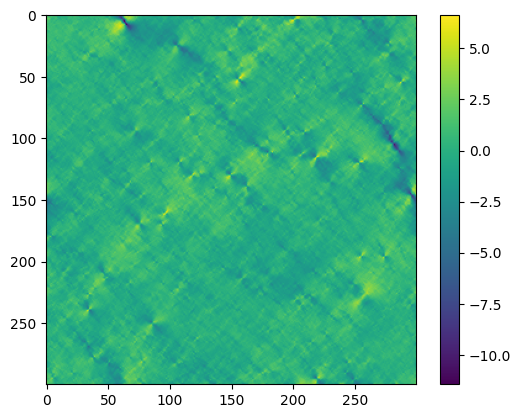

In [12]:
plt.imshow(test[0,1,:,:])
plt.colorbar()
plt.show() #Now getting a shear map which is normalised  :)))))

In [13]:
gens_mmGAN = torch.zeros(size=(32,300,300,2)).cuda()

In [14]:
test_float = normalised_gamma.float()

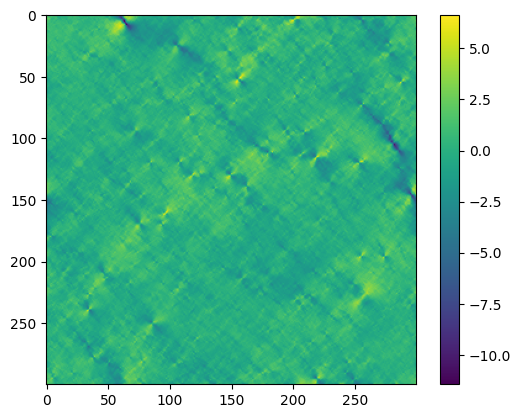

In [15]:
plt.imshow(test_float[0,1,:,:].cpu())
plt.colorbar()
plt.show() #Now getting a shear map which is normalised  :)))))

In [23]:
for z in range(1):
    gens_mmGAN[z,:,:,:] = mmGAN_model.reformat(mmGAN_model.forward(normalised_gamma).cuda())

RuntimeError: Input type (double) and bias type (float) should be the same

In [24]:
new_test = gens_mmGAN.cpu().detach().numpy()

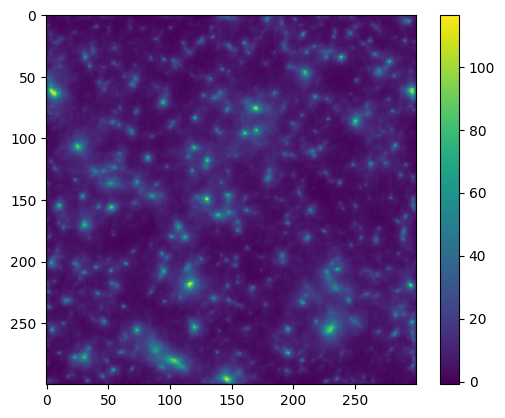

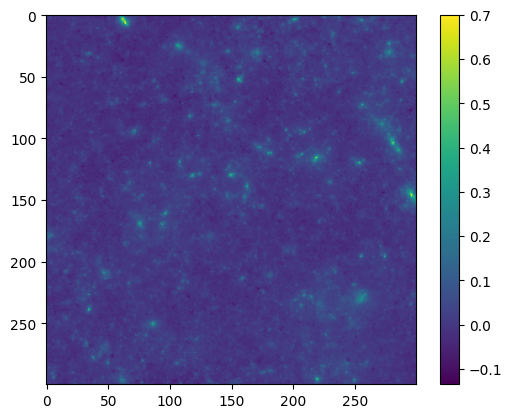

In [25]:
plt.imshow(new_test[0,:,:,0])
plt.colorbar()
plt.show()
plt.imshow(ground_truth)
plt.colorbar()
plt.show()